In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [29]:
# Load the final results CSV for both models
df_aasist = pd.read_csv("final_results.csv")
df_aasist_l = pd.read_csv("final_results2.csv")  # AASIST-L model

# Define the classification threshold
THRESHOLD = 0.5

# Function to clean accent names (remove parentheses and anything after)
def clean_accent_name(accent):
    return accent.split("(")[0].strip()

# Apply cleaning function to both datasets
df_aasist["region"] = df_aasist["region"].apply(clean_accent_name)
df_aasist_l["region"] = df_aasist_l["region"].apply(clean_accent_name)

# Create binary labels: 1 = Spoof (Fake), 0 = Real
df_aasist["predicted_spoof"] = (df_aasist["prediction_score"] >= THRESHOLD).astype(int)
df_aasist_l["predicted_spoof"] = (df_aasist_l["prediction_score"] >= THRESHOLD).astype(int)

# Assuming ground truth is all real (0) since FPR assumes no spoofed examples
df_aasist["actual_label"] = 0
df_aasist_l["actual_label"] = 0

# Compute FP (False Positives) and TN (True Negatives)
df_aasist["FP"] = (df_aasist["predicted_spoof"] == 1) & (df_aasist["actual_label"] == 0)
df_aasist["TN"] = (df_aasist["predicted_spoof"] == 0) & (df_aasist["actual_label"] == 0)

df_aasist_l["FP"] = (df_aasist_l["predicted_spoof"] == 1) & (df_aasist_l["actual_label"] == 0)
df_aasist_l["TN"] = (df_aasist_l["predicted_spoof"] == 0) & (df_aasist_l["actual_label"] == 0)

# Group by 'region' and compute FPR and TNR for both models
region_metrics_aasist = df_aasist.groupby("region").agg(
    total_samples=("actual_label", "count"),
    false_positives=("FP", "sum"),
    true_negatives=("TN", "sum")
)

region_metrics_aasist_l = df_aasist_l.groupby("region").agg(
    total_samples=("actual_label", "count"),
    false_positives=("FP", "sum"),
    true_negatives=("TN", "sum")
)

# Calculate FPR and TNR
region_metrics_aasist["FPR"] = region_metrics_aasist["false_positives"] / region_metrics_aasist["total_samples"]
region_metrics_aasist["TNR"] = region_metrics_aasist["true_negatives"] / region_metrics_aasist["total_samples"]

region_metrics_aasist_l["FPR"] = region_metrics_aasist_l["false_positives"] / region_metrics_aasist_l["total_samples"]
region_metrics_aasist_l["TNR"] = region_metrics_aasist_l["true_negatives"] / region_metrics_aasist_l["total_samples"]

# Reset index for plotting
region_metrics_aasist = region_metrics_aasist.reset_index()
region_metrics_aasist_l = region_metrics_aasist_l.reset_index()

# Add a model identifier
region_metrics_aasist["Model"] = "AASIST"
region_metrics_aasist_l["Model"] = "AASIST-L"



In [30]:
from scipy import stats
import matplotlib.pyplot as plt

# Function to calculate confidence intervals for proportions using Wilson Score Interval
def compute_confidence_interval(proportion, total, confidence=0.95):
    """Compute the confidence interval for a proportion using the Wilson Score Interval."""
    if total == 0:
        return (0, 0)
    z = stats.norm.ppf((1 + confidence) / 2)  # Z-score for confidence level
    p = proportion
    n = total
    center = (p + (z**2) / (2 * n)) / (1 + (z**2) / n)
    margin = (z * np.sqrt((p * (1 - p) / n) + (z**2) / (4 * n**2))) / (1 + (z**2) / n)
    return center - margin, center + margin

# Compute confidence intervals for FPR & TNR for both models
region_metrics_aasist["FPR_CI_Lower"], region_metrics_aasist["FPR_CI_Upper"] = zip(*region_metrics_aasist.apply(
    lambda row: compute_confidence_interval(row["FPR"], row["total_samples"]),
    axis=1
))

region_metrics_aasist_l["FPR_CI_Lower"], region_metrics_aasist_l["FPR_CI_Upper"] = zip(*region_metrics_aasist_l.apply(
    lambda row: compute_confidence_interval(row["FPR"], row["total_samples"]),
    axis=1
))

region_metrics_aasist["TNR_CI_Lower"], region_metrics_aasist["TNR_CI_Upper"] = zip(*region_metrics_aasist.apply(
    lambda row: compute_confidence_interval(row["TNR"], row["total_samples"]),
    axis=1
))

region_metrics_aasist_l["TNR_CI_Lower"], region_metrics_aasist_l["TNR_CI_Upper"] = zip(*region_metrics_aasist_l.apply(
    lambda row: compute_confidence_interval(row["TNR"], row["total_samples"]),
    axis=1
))

# Reset index for plotting
region_metrics_aasist = region_metrics_aasist.reset_index()
region_metrics_aasist_l = region_metrics_aasist_l.reset_index()

# Add model identifier
region_metrics_aasist["Model"] = "AASIST"
region_metrics_aasist_l["Model"] = "AASIST-L"

# Combine both dataframes
combined_fpr = pd.concat([region_metrics_aasist[["region", "FPR", "FPR_CI_Lower", "FPR_CI_Upper", "Model"]], 
                          region_metrics_aasist_l[["region", "FPR", "FPR_CI_Lower", "FPR_CI_Upper", "Model"]]])

combined_tnr = pd.concat([region_metrics_aasist[["region", "TNR", "TNR_CI_Lower", "TNR_CI_Upper", "Model"]], 
                          region_metrics_aasist_l[["region", "TNR", "TNR_CI_Lower", "TNR_CI_Upper", "Model"]]])


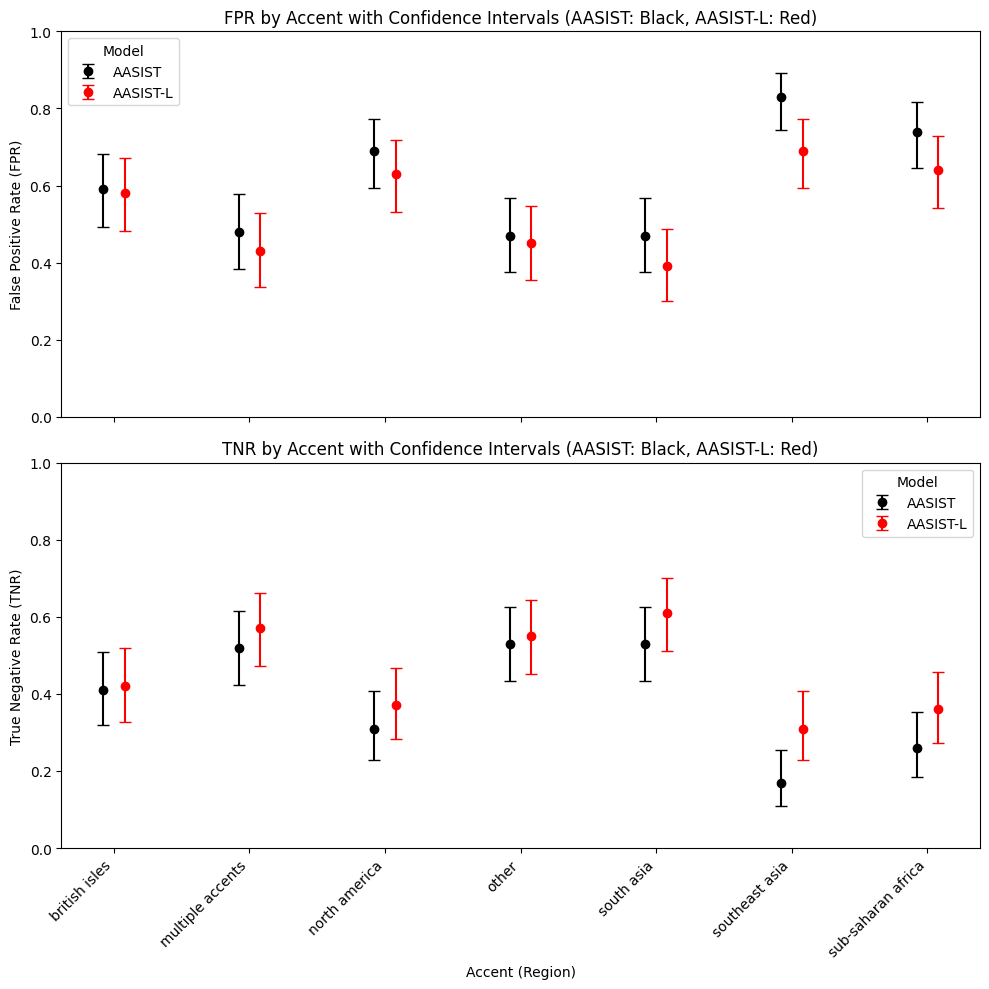

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Create a vertically stacked plot for FPR and TNR
fig, axes = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

offset = 0.08  # Offset for AASIST-L to shift slightly to the right

# Plot FPR with confidence intervals on the first subplot
for model, color, shift in zip(["AASIST", "AASIST-L"], ["black", "red"], [-offset, offset]):
    subset = combined_fpr[combined_fpr["Model"] == model]
    x_positions = np.arange(len(subset["region"])) + shift  # Apply offset
    axes[0].errorbar(x_positions, subset["FPR"], 
                      yerr=[subset["FPR"] - subset["FPR_CI_Lower"], subset["FPR_CI_Upper"] - subset["FPR"]], 
                      fmt="o", color=color, capsize=4, label=model)

axes[0].set_ylabel("False Positive Rate (FPR)")
axes[0].set_title("FPR by Accent with Confidence Intervals (AASIST: Black, AASIST-L: Red)")
axes[0].legend(title="Model")
axes[0].set_ylim(0, 1)  # Ensure values are between 0 and 1

# Plot TNR with confidence intervals on the second subplot
for model, color, shift in zip(["AASIST", "AASIST-L"], ["black", "red"], [-offset, offset]):
    subset = combined_tnr[combined_tnr["Model"] == model]
    x_positions = np.arange(len(subset["region"])) + shift  # Apply offset
    axes[1].errorbar(x_positions, subset["TNR"], 
                      yerr=[subset["TNR"] - subset["TNR_CI_Lower"], subset["TNR_CI_Upper"] - subset["TNR"]], 
                      fmt="o", color=color, capsize=4, label=model)

axes[1].set_ylabel("True Negative Rate (TNR)")
axes[1].set_title("TNR by Accent with Confidence Intervals (AASIST: Black, AASIST-L: Red)")
axes[1].legend(title="Model")
axes[1].set_ylim(0, 1)  # Ensure values are between 0 and 1

# Set x-axis labels and ticks
plt.xticks(ticks=np.arange(len(combined_fpr["region"].unique())), 
           labels=combined_fpr["region"].unique(), rotation=45, ha="right")
plt.xlabel("Accent (Region)")

plt.tight_layout()
plt.show()

In [42]:
combined_tnr

,region,TNR,TNR_CI_Lower,TNR_CI_Upper,Model
0,british isles,0.41,0.318673,0.507986,AASIST
1,multiple accents,0.52,0.423166,0.615354,AASIST
2,north america,0.31,0.227797,0.406261,AASIST
3,other,0.53,0.432889,0.624892,AASIST
4,south asia,0.53,0.432889,0.624892,AASIST
5,southeast asia,0.17,0.108936,0.255480,AASIST
6,sub-saharan africa,0.26,0.184047,0.353710,AASIST
0,british isles,0.42,0.327984,0.517935,AASIST-L
1,multiple accents,0.57,0.472154,0.662667,AASIST-L
2,north america,0.37,0.281824,0.467795,AASIST-L
